#### 필요한 라이브러리 호출

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

#### 데이터 불러오기 & 훈련/테스트용 데이터 분리

In [4]:
from google.colab import files # 구글 코랩 파일 업로드하기
file_uploaded=files.upload()

Saving train.csv to train.csv


In [6]:
# 데이터 불러오기
train =  pd.read_csv('train.csv', dtype = np.float32)

# 데이터를 features & labels로 분리하기
targets_numpy = train.label.values  # 레이블
features_numpy = train.loc[:, train.columns != 'label'].values / 255  # 정규화

# 훈련용, 테스트용 데이터 분리하기 (비율은 8;2)
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                              targets_numpy,
                                                                              test_size=0.2,
                                                                              random_state=42)


#### 텐서 생성 및 데이터로더로 불러오기

In [7]:
# 훈련용 데이터셋에 대한 feature, label 텐서 만들기
# 그레디언트 축적하기 위해 텐서 먼저 만들고, variable 만들기
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)

# 테스트용 데이터셋에 대한 feature, label 텐서 만들기
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

# 배치사이즈, 에포크, iteration 지정하기
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
print("Epoch Number: ", num_epochs)

# Pytorch 훈련, 검증용 데이터셋
train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest, targetsTest)

# 데이터로더로 불러오기
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

Epoch Number:  17


#### 데이터셋 시각화

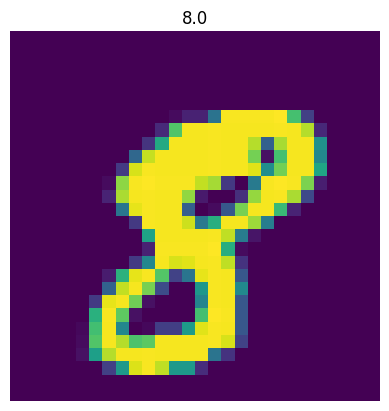

33600
8400


In [8]:
# 데이터셋에 있는 임의의 이미지 하나 시각화
plt.imshow(features_numpy[10].reshape(28, 28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

print(len(train_loader.dataset))
print(len(test_loader.dataset))

#### 모델 생성
- LSTM

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()

        # LSTM의 hidden state 차원(hidden state 벡터 길이)
        self.hidden_dim = hidden_dim

        # LSTM 레이어 개수 (stacked LSTM layers)
        self.layer_dim = layer_dim

        # LSTM 레이어 정의
        # input_dim : 입력 데이터의 feature 개수
        # hidden_dim : LSTM의 hidden state 차원
        # layer_dim : LSTM 레이어 수
        # batch_first=True : 입력 데이터의 첫 번째 차원을 배치(batch)로 설정
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # 출력 레이어 정의 (fully connected layer)
        # hidden_dim -> output_dim으로 매핑
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # LSTM의 초기 hidden state (h0) 0으로 초기화
        # shape : (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # LSTM의 초기 cell state (c0) 0으로 초기화
        # shape : (layer_dim, batch_size, hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # LSTM에 입력 데이터 x와 초기 hidden state, cell state 전달
        # out : 모든 타임스텝의 hidden state 출력
        # hn : 마지막 타임스텝의 hidden state
        # cn : 마지막 타임스텝의 cell state
        # detach() 호출하여 이전 배치의 연산 그래프 연결 끊음
        # 28개의 타임스텝 존재
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # 마지막 타임스텝의 hidden state 사용하여 출력값 생성
        # out[:, -1, :]은 마지막 타임스텝의 hidden state 추출
        # out.size() -> (100, 28, 100) // out[:, -1, :] -> (100, 100)
        out = self.fc(out[:, -1, :])
        # out.size() -> (100, 10)

        return out

#### 변수 지정 & 모델 선언 & 옵티마이저 및 손실함수 지정

In [10]:
input_dim = 28   # 입력 데이터의 feature 차원
hidden_dim = 100  # LSTM hidden state 차원
layer_dim = 1   # LSTM 레이어 수
output_dim = 10   # 출력 데이터 차원(클래스 수)

# LSTM 모델
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)

# 손실 함수
error = nn.CrossEntropyLoss()

# 학습률 설정
learning_rate = 0.1

# 옵티마이저 설정 : 확률적 경사 하강법(SGD)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### 모델 학습을 위한 하이퍼파라미터 설정 및 학습

In [11]:
seq_dim = 28  # 시퀀스 길이(타임스텝)
loss_list = []  # 손실 값 저장할 리스트
iteration_list = []  # 반복 횟수 저장할 리스트
accuracy_list = []   # 정확도 저장할 리스트
count = 0  # 총 학습 반복 수를 세는 변수

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # 이미지를 (batch_size, seq_dim, input_dim) 형태로 변환하고 gradient 추적 활성화
        images = images.view(-1, seq_dim, input_dim).requires_grad_()
        # 옵티마이저 gradient 초기화
        optimizer.zero_grad()
        # 모델 순전파(forward pass) 수행하여 출력 계산
        outputs = model(images)
        # 손실 계산
        loss = error(outputs, labels)
        # 역전파(backward pass) 통해 gradient 계산
        loss.backward()
        # 파라미터 업데이트
        optimizer.step()
        # 반복 횟수 증가
        count += 1

        if count % 500 == 0:
            # 정확도 계산 위한 변수 초기화
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, seq_dim, input_dim)

                outputs = model(images)
                # 가장 높은 값 가지는 클래스 예측
                _, predicted = torch.max(outputs.data, 1)
                # 총 라벨 개수 계산
                total += labels.size(0)
                # 정확히 예측된 라벨 수 계산
                correct += (predicted == labels).sum()

            accuracy = 100 * correct / total # 정확도 계산
            # 손실 및 정확도 기록
            loss_list.append(loss.data.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

Iteration: 500  Loss: 2.271587610244751  Accuracy: 19.095237731933594 %
Iteration: 1000  Loss: 1.2203459739685059  Accuracy: 46.75 %
Iteration: 1500  Loss: 0.49860256910324097  Accuracy: 80.10713958740234 %
Iteration: 2000  Loss: 0.2585972547531128  Accuracy: 91.11904907226562 %
Iteration: 2500  Loss: 0.14115062355995178  Accuracy: 93.08333587646484 %
Iteration: 3000  Loss: 0.14880676567554474  Accuracy: 95.19047546386719 %
Iteration: 3500  Loss: 0.16578830778598785  Accuracy: 95.67857360839844 %
Iteration: 4000  Loss: 0.022911304607987404  Accuracy: 96.19047546386719 %
Iteration: 4500  Loss: 0.08661877363920212  Accuracy: 96.42857360839844 %
Iteration: 5000  Loss: 0.035815175622701645  Accuracy: 97.03571319580078 %
Iteration: 5500  Loss: 0.11130614578723907  Accuracy: 97.03571319580078 %


#### 결과 확인 및 시각화

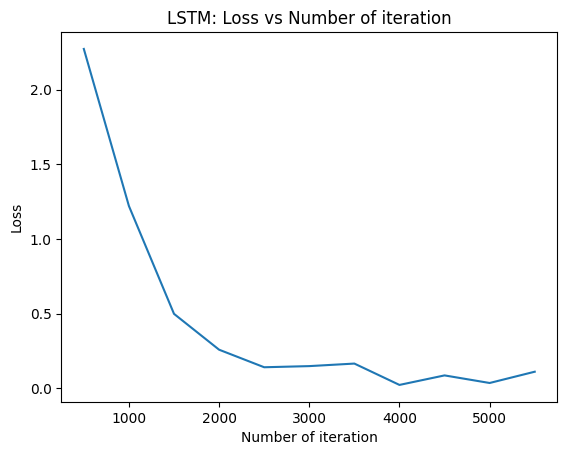

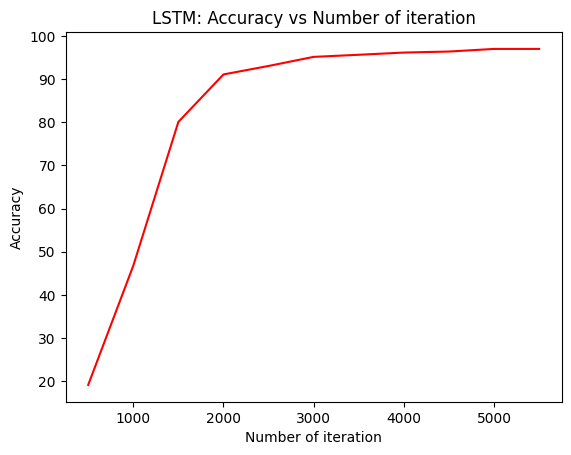

In [12]:
# loss 시각화
# 학습 반복(iteration)에 따른 손실 변화를 나타낸 그래프
plt.plot(iteration_list, loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("LSTM: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
# 학습 반복(iteration)에 따른 정확도 변화를 나타낸 그래프
plt.plot(iteration_list, accuracy_list, color='red')
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("LSTM: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()